In [1]:
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm

In [2]:
from torchvision.models import alexnet
from torchvision.models import vgg11
from torchvision.models import googlenet
from torchvision.models import resnet18

In [ ]:
model = resnet18()

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
def get_pretrained_model(model_name: str, num_classes: int, pretrained: bool=True):
    if model_name == 'alexnet':
        model = alexnet(pretrained = pretrained)
        model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
    elif model_name == 'vgg11':
        model = vgg11(pretrained = pretrained)
        model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
    elif model_name == 'googlenet':
        model = googlenet(pretrained = pretrained)
        model.fc = nn.Linear(in_features=1024, out_features=num_classes, bias=True)
    elif model_name == 'resnet18':
        model = resnet18(pretrained = pretrained)
        model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)
    return model


In [4]:
def get_normalize(features: torch.Tensor):
    means = (features.data/255).mean(axis=(0, 1, 2))
    stdf = (features.data/255).std(axis=(0, 1, 2))
    # x = features.view(n.size(1), -1).mean(1)
    # y = features.view(n.size(1), -1).std(1)
    return means, stdf
train_dataset = CIFAR10(root="../datasets/", train=True, download=True, transform=T.ToTensor())
test_dataset = CIFAR10(root="../datasets/", train=False, download=True, transform=T.ToTensor())
means, stds = get_normalize(train_dataset)

100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


Extracting ../datasets/cifar-10-python.tar.gz to ../datasets/
Files already downloaded and verified


In [5]:
train_transforms = T.Compose(
    [
        T.Resize((224, 224)),
        T.AutoAugment(T.AutoAugmentPolicy.CIFAR10),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)
train_dataset  = CIFAR10(root="../datasets/", train=True, transform=train_transforms)
test_dataset = CIFAR10(root="../datasets/", train=True, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
model = get_pretrained_model('resnet18', 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


In [7]:
#!g1.1
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

#!g1.1
import torch


@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy




#!g1.1
import matplotlib.pyplot as plt
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

#!g1.1
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

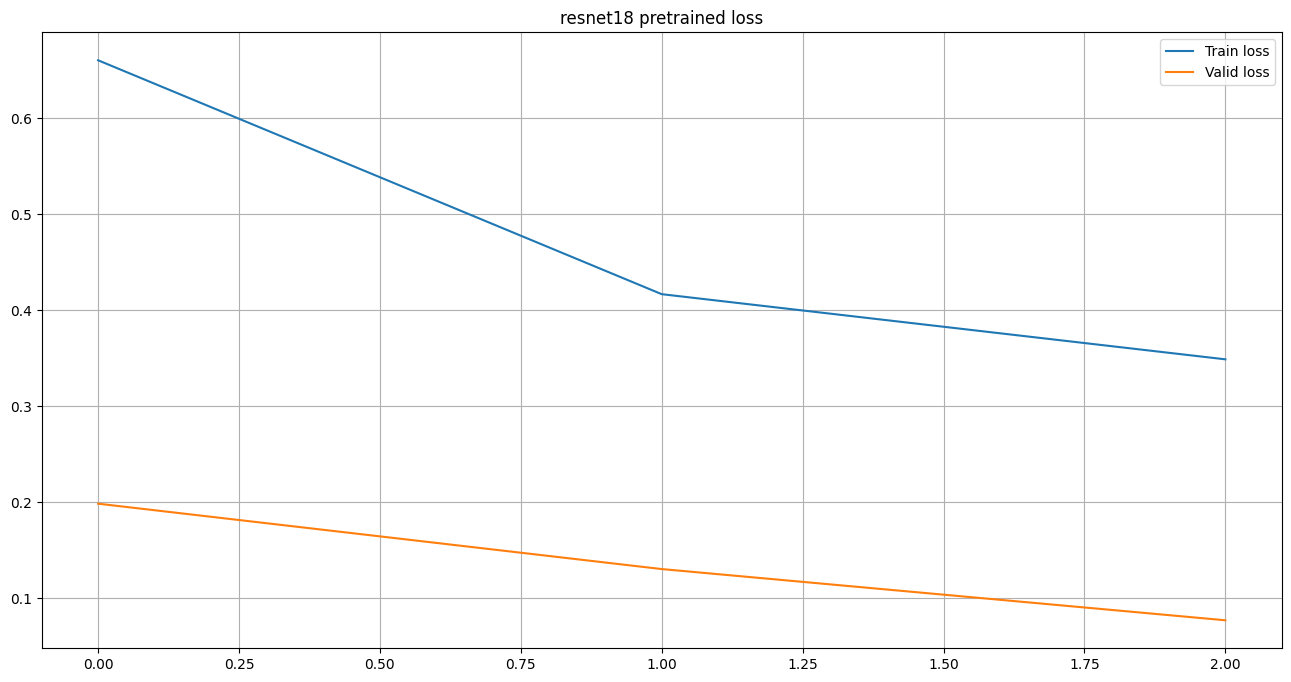

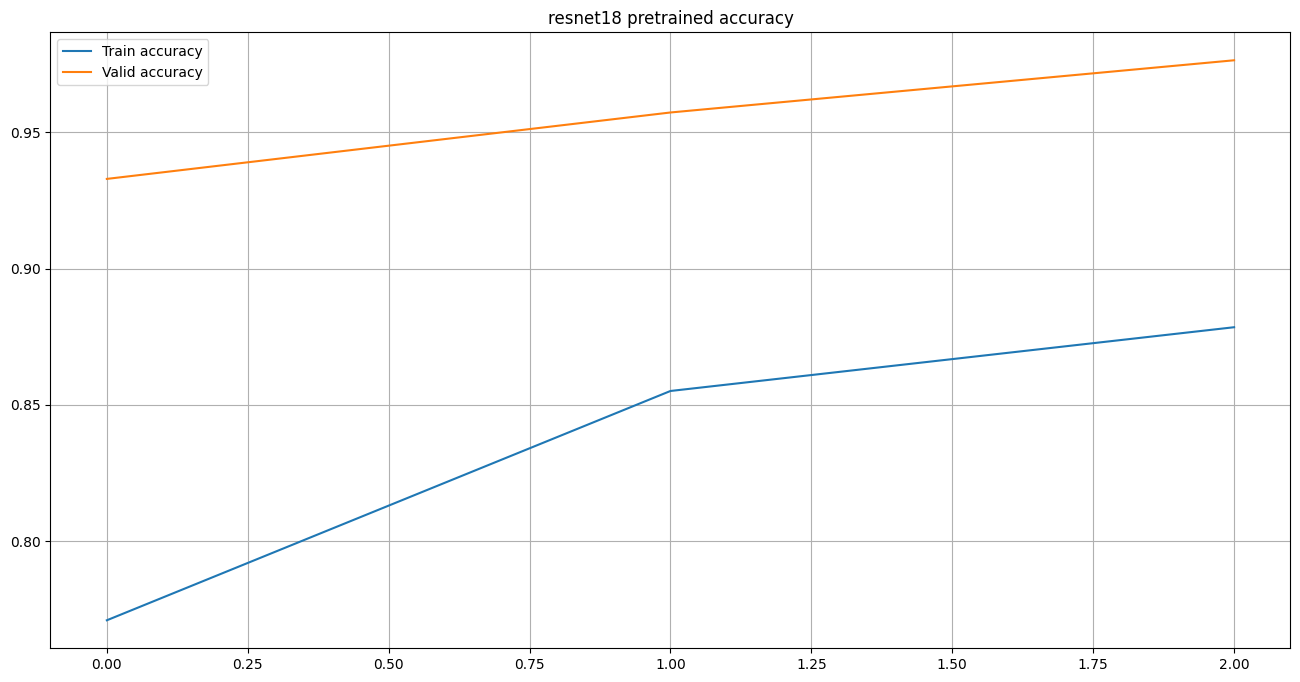

Train:  94%|█████████▎| 366/391 [02:12<00:09,  2.77it/s]


KeyboardInterrupt: 

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

model.requires_grad_(False)
model.layer4.requires_grad_(True)
model.fc.requires_grad_(True)

optimizer = Adam(
    [
        {'params': model.fc.parameters(), 'lr': 1e-3},
        {'params': model.layer4.parameters(), 'lr': 1e-4}
    ]
)

whole_train_valid_cycle(model, 10, 'resnet18 pretrained')

In [10]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Проверка на случай, если нужно изменить размерность для skip-connection
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = x

        # Первый сверточный слой
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Второй сверточный слой
        out = self.conv2(out)
        out = self.bn2(out)

        # Добавление skip-connection
        out += self.shortcut(residual)
        out = self.relu(out)

        return out

In [11]:
class create_advanced_skip_connection_conv_cifar(nn.Module):
    def __init__(self):
        super().__init__()

        # Изменили размер линейного слоя в зависимости от выходного размера
        self.net1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # 224 x 224 x 16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112 x 112 x 16
        )
        self.block1 = BasicBlock(in_channels=16, out_channels=16)
        self.net2 = nn.Sequential(

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # 112 x 112 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56 x 56 x 32
        )
        self.block2 = BasicBlock(in_channels=32, out_channels=32)
        self.net3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 56 x 56 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28 x 28 x 64
        )
        self.block3 = BasicBlock(in_channels=64, out_channels=64)


        self.net4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 28 x 28 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14 x 14 x 128
        )
        self.block4 = BasicBlock(in_channels=128, out_channels=128)

        self.Linear = nn.Sequential(
            nn.Flatten(),

            # Размер после сверток и пулинга: 14 * 14 * 128 = 25088
            nn.Linear(14 * 14 * 128, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            # nn.Dropout(p=0.3),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # 10 классов для CIFAR-10
        )

    def forward(self, x):
        x = self.net1(x)
        x =self.block1(x) + x
        x = self.net2(x)
        x = self.block2(x) + x
        x = self.net3(x)
        x = self.block3(x) + x
        x = self.net4(x)
        x = self.block4(x) + x
        x = self.Linear(x)
        return x

In [12]:
model = create_advanced_skip_connection_conv_cifar()

In [13]:
model

create_advanced_skip_connection_conv_cifar(
  (net1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block1): BasicBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Identity()
  )
  (net2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPoo

In [17]:
from torch.optim.lr_scheduler import StepLR
loss_fn = nn.CrossEntropyLoss()
model = create_advanced_skip_connection_conv_cifar().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

scheduler = StepLR(optimizer, step_size=25)

n_epoch = 12

for epoch in range(n_epoch):
  train_loss, train_accuracy = train(model)
  valid_loss, valid_accuracy = evaluate(model, valid_loader)
  print(f"Epoch [{epoch+1}/{n_epoch}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")


Evaluation: 100%|██████████| 391/391 [01:32<00:00,  4.25it/s]


Epoch [1/12], Train Loss: 1.4593, Train Accuracy: 0.47%, Valid Loss: 1.1495, Valid Accuracy: 0.59%


Evaluation: 100%|██████████| 391/391 [01:31<00:00,  4.26it/s]


Epoch [2/12], Train Loss: 1.0376, Train Accuracy: 0.63%, Valid Loss: 0.7175, Valid Accuracy: 0.75%


Evaluation: 100%|██████████| 391/391 [01:30<00:00,  4.31it/s]


Epoch [3/12], Train Loss: 0.8829, Train Accuracy: 0.69%, Valid Loss: 0.5830, Valid Accuracy: 0.80%


Evaluation: 100%|██████████| 391/391 [01:40<00:00,  3.88it/s]


Epoch [4/12], Train Loss: 0.7847, Train Accuracy: 0.72%, Valid Loss: 0.6211, Valid Accuracy: 0.79%


Evaluation: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]


Epoch [5/12], Train Loss: 0.7068, Train Accuracy: 0.75%, Valid Loss: 0.4987, Valid Accuracy: 0.84%


Evaluation: 100%|██████████| 391/391 [01:30<00:00,  4.31it/s]


Epoch [6/12], Train Loss: 0.6499, Train Accuracy: 0.77%, Valid Loss: 0.4191, Valid Accuracy: 0.87%


Evaluation: 100%|██████████| 391/391 [01:31<00:00,  4.26it/s]


Epoch [7/12], Train Loss: 0.5706, Train Accuracy: 0.80%, Valid Loss: 0.3182, Valid Accuracy: 0.89%


Evaluation: 100%|██████████| 391/391 [01:32<00:00,  4.24it/s]


Epoch [8/12], Train Loss: 0.5108, Train Accuracy: 0.82%, Valid Loss: 0.2790, Valid Accuracy: 0.92%


Evaluation: 100%|██████████| 391/391 [01:32<00:00,  4.24it/s]


Epoch [9/12], Train Loss: 0.4746, Train Accuracy: 0.84%, Valid Loss: 0.3941, Valid Accuracy: 0.87%


Evaluation: 100%|██████████| 391/391 [01:40<00:00,  3.89it/s]


Epoch [10/12], Train Loss: 0.4476, Train Accuracy: 0.84%, Valid Loss: 0.1637, Valid Accuracy: 0.95%


Evaluation: 100%|██████████| 391/391 [01:31<00:00,  4.27it/s]


Epoch [11/12], Train Loss: 0.3865, Train Accuracy: 0.87%, Valid Loss: 0.2018, Valid Accuracy: 0.95%


Evaluation: 100%|██████████| 391/391 [01:30<00:00,  4.32it/s]

Epoch [12/12], Train Loss: 0.3580, Train Accuracy: 0.88%, Valid Loss: 0.2592, Valid Accuracy: 0.94%
